In [ ]:
!pip install albumentations==0.4.6

In [ ]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import re
from collections import Counter

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
#from collections import defaunltdict
import gensim.downloader

import os


# data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# pretrained models
import torchvision
from torchvision import models, transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# set up kaggle data download
! rm -rf ~/.kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/usf/kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d crowww/a-large-scale-fish-dataset
! unzip -q a-large-scale-fish-dataset.zip


a-large-scale-fish-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT/00001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N



In [ ]:
! rm /content/Fish_Dataset/Fish_Dataset/README.txt
! rm /content/Fish_Dataset/Fish_Dataset/Segmentation_example_script.m
! rm /content/Fish_Dataset/Fish_Dataset/license.txt

In [ ]:
# create a dataframe for our data
data_path = 'Fish_Dataset'



rows = []
for dataset in os.listdir(data_path):
    for label in os.listdir(data_path + f'/{dataset}'):
        for image in os.listdir(data_path + f'/{dataset}' + f'/{label}'):
          for image_file in os.listdir(data_path + f'/{dataset}' + f'/{label}'+f'/{image}'):
              row = dict()
              row['image_file'] = image
              row['label'] = label
              row['dataset'] = dataset
        
            # a bit redudant, could build from other data in __getitem__ if wanted
              row['image_path'] = data_path + f'/{dataset}' + f'/{label}'+f'/{image}' + f'/{image_file}' 
              rows.append(row)
        
df = pd.DataFrame(rows)
print(len(df))
df.head()

18000


,image_file,label,dataset,image_path
0,Shrimp,Shrimp,Fish_Dataset,Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00225.png
1,Shrimp,Shrimp,Fish_Dataset,Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00561.png
2,Shrimp,Shrimp,Fish_Dataset,Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00902.png
3,Shrimp,Shrimp,Fish_Dataset,Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00723.png
4,Shrimp,Shrimp,Fish_Dataset,Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00745.png


In [ ]:
len(df)

18000

In [ ]:
# exclude all data in GT folders
df = df[~df['image_path'].str.contains('GT')]

In [ ]:
len(df)

9000

In [ ]:
df.head()

,image_file,label,dataset,image_path
0,Shrimp,Shrimp,Fish_Dataset,Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00225.png
1,Shrimp,Shrimp,Fish_Dataset,Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00561.png
2,Shrimp,Shrimp,Fish_Dataset,Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00902.png
3,Shrimp,Shrimp,Fish_Dataset,Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00723.png
4,Shrimp,Shrimp,Fish_Dataset,Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00745.png


In [ ]:
# split into training and validation set 
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_df.head()

,image_file,label,dataset,image_path
12317,Black Sea Sprat,Black Sea Sprat,Fish_Dataset,Fish_Dataset/Fish_Dataset/Black Sea Sprat/Blac...
740,Shrimp,Shrimp,Fish_Dataset,Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00711.png
6781,Red Sea Bream,Red Sea Bream,Fish_Dataset,Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Se...
15850,Gilt-Head Bream,Gilt-Head Bream,Fish_Dataset,Fish_Dataset/Fish_Dataset/Gilt-Head Bream/Gilt...
4963,Trout,Trout,Fish_Dataset,Fish_Dataset/Fish_Dataset/Trout/Trout/00252.png


In [ ]:
df.iloc[0]['image_path']

'Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00225.png'

In [ ]:
import cv2

# pull up an image
row = df.iloc[0]
image_path = row['image_path']
img = cv2.imread(image_path)

# what is an image?
img

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [ ]:
#check our image size (3 channels because it's RGB images) 
print(img.shape)

# pixel intensity goes from 0 to 255
print(np.max(img), np.min(img))

(445, 590, 3)
255 0


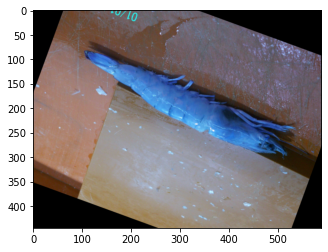

In [ ]:
# look at the image
plt.imshow(img)

In [ ]:
# Let's create a Dataset for our fish images
# we apply augmentation on our images

class FishDataset(Dataset):
    def __init__(self, df, augment=True):
        self.df = df
        
        # label dictionary
        self.label_dict = {'Black Sea Sprat': 0,
                            'Gilt-Head Bream': 1,
                            'Hourse Mackerel': 2,
                            'Red Mullet': 3,
                            'Red Sea Bream': 4,
                            'Sea Bass': 5,
                            'Shrimp': 6,
                            'Striped Red Mullet': 7,
                            'Trout': 8}
           # define the transformation
        if augment == True:
            self.transforms = A.Compose([
                # spatial transforms
                A.RandomCrop(width=224, height=224),
                A.ElasticTransform(p=1),
                
                # this adjusts from [0,255] to [0,1]
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
        else:
            self.transforms = A.Compose([
                # training/valid images have same size
                A.CenterCrop(width=224, height=224),
                
                # normalize
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # get ingredients for retrieving image
        image_path = row['image_path']
        #fname = row['image_file']
        #path = image_path+'/'+fname
        
        # read the img
        img = cv2.imread(image_path)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # move color channels to correct spot
        img = np.transpose(img, (2, 0, 1))
        
        # convert to [0,1] scale
        img = torch.tensor(img / 255.).float()
        
        label = torch.tensor(self.label_dict[row['label']])
        
        return img, label

In [ ]:
ds_train = FishDataset(train_df)
dl_train = DataLoader(ds_train, batch_size = 2, shuffle=True)


ds_val = FishDataset(valid_df)
dl_val = DataLoader(ds_val, batch_size = 16, shuffle=True)

In [ ]:
img, label = next(iter(ds_val))

# Pre-trained model

# First model: Alexnet

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
# pretrained models
import torchvision
from torchvision import models, transforms

In [ ]:
# our pre-trained model
alexnet_frozen = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


In [ ]:
# turn off gradients for all the parameters in frozen
for param in alexnet_frozen.parameters():
            param.requires_grad = False

In [ ]:
# re-intialize the last layer for our task
alexnet_frozen.classifier[6] = nn.Linear(4096, 9)

In [ ]:
# pass the appropriate parameters to the optimizer
params_to_update = []

for param in alexnet_frozen.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=0.001)

In [ ]:
alexnet_frozen.modules

<bound method Module.modules of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

In [ ]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x).to(device)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    model.to(device)
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        y_pred = softmax(model(x).to(device))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [ ]:
from tqdm.notebook import tqdm

lossFun = nn.CrossEntropyLoss()

# let's just compare after 3 epoch to save time
# training for more epochs might change the comparison!
num_epochs = 3
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(alexnet_frozen, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(alexnet_frozen, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(alexnet_frozen, dl_train, len(ds_train))
    valid_acc = one_pass_acc(alexnet_frozen, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

Epoch:  0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Train loss:  0.6921210326994053



Valid loss:  0.4305168403131244
Train Acc:  0.8534722222222222
Valid Acc:  0.8383333333333334
Epoch:  1



Train loss:  0.5205419340091685



Valid loss:  0.31026446531666857
Train Acc:  0.9045833333333333
Valid Acc:  0.883888888888889
Epoch:  2



Train loss:  0.4986495467113165



Valid loss:  0.3298408993256105
Train Acc:  0.8851388888888889
Valid Acc:  0.8816666666666667



### Ouput the number of paramaters in alexnet

In [ ]:
pytorch_total_params = sum(p.numel() for p in alexnet_frozen.parameters())
pytorch_total_params

57040713

# Second model: Resnet

In [ ]:
#@title
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x).to(device)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    model.to(device)
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        y_pred = softmax(model(x).to(device))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [ ]:
models_ls = [models.resnet18(pretrained=True), 
             models.resnet34(pretrained=True),
             models.resnet50(pretrained=True),
             models.resnet101(pretrained=True),
             models.resnet152(pretrained=True)]

train_loss_ls = []
val_acc_ls = []
for m in models_ls:
        
    # our pre-trained model
    resnet = models.resnet18(pretrained=True) 
    # turn off gradients for all the parameters in frozen
    for param in resnet.parameters():
                param.requires_grad = False

    resnet.fc = nn.Linear(512, 9)


    lossFun = nn.CrossEntropyLoss()
    
    params_to_update = []

    for param in resnet.parameters():
        if param.requires_grad == True:
            params_to_update.append(param)

    optimizer = optim.Adam(params_to_update, lr=0.05)

    num_epochs = 3
    # train_losses = []
    # valid_losses = []

    for epoch in tqdm(range(num_epochs)):
        print('Epoch: ', epoch)
        
        train_loss = one_pass(resnet, dl_train, optimizer, lossFun)
        # train_losses.append(train_loss)
        # print('Train loss: ', train_loss)
        
        # valid_loss = one_pass(resnet, dl_val, optimizer, lossFun, backwards=False)
        # valid_losses.append(valid_loss)
        # print('Valid loss: ', valid_loss)
        
        # train_acc = one_pass_acc(resnet, dl_train, len(ds_train))
        valid_acc = one_pass_acc(resnet, dl_val, len(ds_val))
        # print('Train Acc: ', train_acc)
        # print('Valid Acc: ', valid_acc)

    train_loss_ls.append(train_loss)
    val_acc_ls.append(valid_acc)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


Epoch:  0


NameError: ignored

In [ ]:
[sum(p.numel() for p in m.parameters()) for m in models_ls]


[11689512, 21797672, 25557032, 44549160, 60192808]

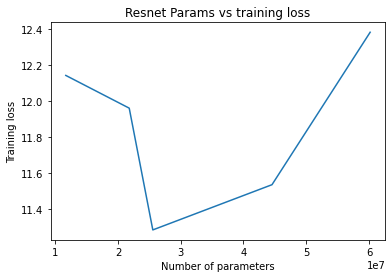

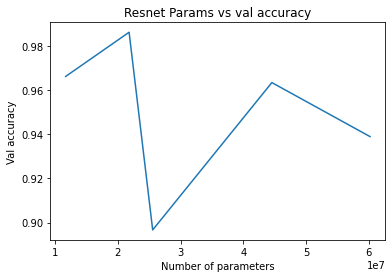

In [ ]:
resnet_params = [sum(p.numel() for p in m.parameters()) for m in models_ls]
plt.plot(resnet_params, train_loss_ls, label='Train loss')
plt.xlabel('Number of parameters')
plt.ylabel('Training loss')
plt.title('Resnet Params vs training loss')
plt.show()
plt.plot(resnet_params, val_acc_ls, label='Val accuracy')
plt.xlabel('Number of parameters')
plt.ylabel('Val accuracy')
plt.title('Resnet Params vs val accuracy')
plt.show()

In [ ]:
# our pre-trained model
resnet = models.resnet18(pretrained=True) 

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [ ]:
# turn off gradients for all the parameters in frozen
for param in resnet.parameters():
            param.requires_grad = False

In [ ]:
resnet.fc = nn.Linear(512, 9)

In [ ]:
# re-initializing the layer reset to default settings
for param in resnet.fc.parameters():
    print(param.requires_grad)

True
True


In [ ]:
# double-check all the parameters
for name, param in resnet.named_parameters():  # none of the layer weights (except the last layer's weights) are updating during training 
    print(f"{name} gradient is set to", param.requires_grad)

In [ ]:
params_to_update = []

for param in resnet.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

print(params_to_update)
optimizer = optim.Adam(params_to_update, lr=0.001)

[Parameter containing:
tensor([[-0.0310,  0.0071,  0.0146,  ...,  0.0279, -0.0281,  0.0253],
        [-0.0403,  0.0175, -0.0374,  ...,  0.0153,  0.0133, -0.0012],
        [ 0.0388,  0.0376,  0.0167,  ...,  0.0285, -0.0337, -0.0238],
        ...,
        [ 0.0338,  0.0232, -0.0071,  ...,  0.0259,  0.0186,  0.0083],
        [-0.0091,  0.0168,  0.0190,  ..., -0.0207,  0.0072, -0.0370],
        [ 0.0297, -0.0353,  0.0053,  ...,  0.0325,  0.0009, -0.0143]],
       requires_grad=True), Parameter containing:
tensor([ 0.0321,  0.0106,  0.0010, -0.0052,  0.0321,  0.0391, -0.0182, -0.0433,
        -0.0066], requires_grad=True)]


In [ ]:

lossFun = nn.CrossEntropyLoss()

# let's just compare after 3 epoch to save time
# training for more epochs might change the comparison!
num_epochs = 3
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(resnet, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(resnet, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(resnet, dl_train, len(ds_train))
    valid_acc = one_pass_acc(resnet, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

Epoch:  0



Train loss:  0.9808418658955229



Valid loss:  0.13386067121693518
Train Acc:  0.9779166666666667
Valid Acc:  0.9755555555555555
Epoch:  1



Train loss:  0.8618766661679061



Valid loss:  0.1454522017620306
Train Acc:  0.9593055555555555
Valid Acc:  0.9577777777777777
Epoch:  2



Train loss:  0.7730701149718111



Valid loss:  0.07287416159612152
Train Acc:  0.9847222222222223
Valid Acc:  0.9866666666666667



### Output the number of parameter in Resnet

In [ ]:
pytorch_total_params_resnet = sum(p.numel() for p in resnet.parameters())
pytorch_total_params_resnet


11181129

# Third model: VGG-19

In [ ]:
# our pre-trained model
VGG19 = models.vgg19(pretrained=True) 

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
VGG19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# turn off gradients for all the parameters in frozen
for param in VGG19.parameters():
            param.requires_grad = False

In [ ]:
# re-intialize the last layer for our task
VGG19.classifier[6] = nn.Linear(4096, 9)

In [ ]:
# pass the appropriate parameters to the optimizer
params_to_update = []

for param in VGG19.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=0.001)

In [ ]:
lossFun = nn.CrossEntropyLoss()

# let's just compare after 3 epoch to save time
# training for more epochs might change the comparison!
num_epochs = 3
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(VGG19, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(VGG19, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(VGG19, dl_train, len(ds_train))
    valid_acc = one_pass_acc(VGG19, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

Epoch:  0



Train loss:  0.3362166141633616



Valid loss:  0.11939328651776356
Train Acc:  0.9659722222222222
Valid Acc:  0.9644444444444444
Epoch:  1



Train loss:  0.18768202220747868



Valid loss:  0.06664197672899211
Train Acc:  0.9802777777777778
Valid Acc:  0.9788888888888889
Epoch:  2



Train loss:  0.1756722301543458



Valid loss:  0.06783491558811537
Train Acc:  0.9772222222222222
Valid Acc:  0.9727777777777777



In [ ]:
pytorch_total_params_vgg19 = sum(p.numel() for p in VGG19.parameters())
pytorch_total_params_vgg19

139607113